In [27]:
# import
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import zipcodes
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [28]:
# read zillow data
with open('../data/Zip_Zhvi_SingleFamilyResidence.csv', 'rb') as f:
    df_zillow = pd.read_csv(f).fillna(0)

# read unemployment data
with open('../data/laucnty17.xlsx', 'rb') as f:
    df_labor = pd.read_excel(f, skiprows=range(1, 6)).fillna(0)

# read crime data
with open('../data/district-of-columbia.xls', 'rb') as f:
    df_crime_dc = pd.read_excel(f, skiprows=range(1, 2)).fillna(0)

with open('../data/maryland.xls', 'rb') as f:
    df_crime_md = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/massachusetts.xls', 'rb') as f:
    df_crime_ma = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/virginia.xls', 'rb') as f:
    df_crime_va = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/new-hampshire.xls', 'rb') as f:
    df_crime_nh = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

In [29]:
# crime columns
#dc_col_list = df_crime_dc.iloc[:, 3:12].columns.tolist()
md_col_list = df_crime_md.iloc[:, 3:12].columns.tolist()
ma_col_list = df_crime_ma.iloc[:, 3:12].columns.tolist()
va_col_list = df_crime_va.iloc[:, 3:12].columns.tolist()
nh_col_list = df_crime_nh.iloc[:, 3:12].columns.tolist()

# crime sum: simplified by summing all offense types
#dc_sum = df_crime_dc[dc_col_list].sum(axis=1)
md_sum = df_crime_md[md_col_list].sum(axis=1)
ma_sum = df_crime_ma[ma_col_list].sum(axis=1)
va_sum = df_crime_va[va_col_list].sum(axis=1)
nh_sum = df_crime_nh[nh_col_list].sum(axis=1)

# crime ratio: offense sum / population
df_md = df_crime_md
df_md['City'] = df_crime_md.iloc[:, 0]
df_md['State'] = 'md'
df_md['Population'] = df_crime_md.iloc[:, 1]
df_md['CrimeRatio'] = md_sum/df_crime_md.iloc[:, 1]
df_md = df_crime_md[['City', 'Population', 'CrimeRatio', 'State']]

df_ma = df_crime_ma
df_ma['City'] = df_crime_ma.iloc[:, 0]
df_ma['State'] = 'ma'
df_ma['Population'] = df_crime_ma.iloc[:, 1]
df_ma['CrimeRatio'] = ma_sum/df_crime_ma.iloc[:, 1]
df_ma = df_crime_ma[['City', 'Population', 'CrimeRatio', 'State']]

df_va = df_crime_va
df_va['City'] = df_crime_va.iloc[:, 0]
df_va['State'] = 'va'
df_va['Population'] = df_crime_va.iloc[:, 1]
df_va['CrimeRatio'] = va_sum/df_crime_va.iloc[:, 1]
df_va = df_crime_va[['City', 'Population', 'CrimeRatio', 'State']]

df_nh = df_crime_nh
df_nh['City'] = df_crime_nh.iloc[:, 0]
df_nh['State'] = 'nh'
df_nh['Population'] = df_crime_nh.iloc[:, 1]
df_nh['CrimeRatio'] = nh_sum/df_crime_nh.iloc[:, 1]
df_nh = df_crime_nh[['City', 'Population', 'CrimeRatio', 'State']]

# combine dataframe
df_crime = pd.concat([df_md, df_ma, df_va, df_nh])

# remove unneeded column
df_crime.drop(['Population'], axis=1, inplace=True)

# convert to lowercase
df_crime[['City', 'State']] = df_crime[['City', 'State']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)

In [30]:
# restructure labor columns
df_labor = pd.DataFrame(df_labor.iloc[:, [3,9]])
df_labor.columns = ['Location', 'Unemployment']
df_labor[['CountyName', 'State']] = df_labor['Location'].str.split(',', expand=True)
df_labor.drop(['Location'], axis=1, inplace=True)

In [31]:
# convert non-timeseries
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].astype(str)
df_zillow[['RegionID', 'RegionName', 'SizeRank']] = df_zillow[['RegionID', 'RegionName', 'SizeRank']].astype(int)

# convert to lowercase
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)
df_labor[['CountyName', 'State']] = df_labor[['CountyName', 'State']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)

# remove redundant suffix
df_labor[['CountyName']] = df_labor['CountyName'].str.rstrip('county').map(lambda x: x.strip())

In [32]:
# arkansas metro areas
hot_springs = df_zillow.loc[(df_zillow['Metro'] == 'hot springs') & (df_zillow['State'] == 'ar')]
little_rock = df_zillow.loc[(df_zillow['Metro'] == 'little rock') & (df_zillow['State'] == 'ar')]
fayetteville = df_zillow.loc[(df_zillow['Metro'] == 'fayetteville') & (df_zillow['State'] == 'ar')]
searcy = df_zillow.loc[(df_zillow['Metro'] == 'searcy') & (df_zillow['State'] == 'ar')]

In [33]:
# merge dataframes
df = pd.merge(df_zillow, df_labor, on=['CountyName', 'State'])
df = pd.merge(df, df_crime, on=['City', 'State'])

# timeseries data
ts_start = df.columns.get_loc('1996-04') + 1
ts_end = df.columns.get_loc('2017-09')
date_columns = df.iloc[:, ts_start:ts_end].columns.tolist()

# ensure integer timeseries
df[date_columns] = df[date_columns].astype(int)

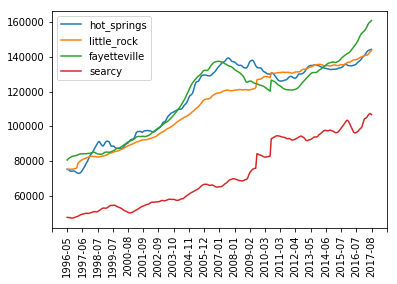

In [34]:
# timeseries plot
fig, ax = plt.subplots()
ax.plot(hot_springs[date_columns].mean(), linestyle='solid')
ax.plot(little_rock[date_columns].mean(), linestyle='solid')
ax.plot(fayetteville[date_columns].mean(), linestyle='solid')
ax.plot(searcy[date_columns].mean(), linestyle='solid')

# decrease ticks
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax, 23), 2))

# rotate ticks + show legend
plt.xticks(rotation=90)
plt.gca().legend(('hot_springs', 'little_rock', 'fayetteville', 'searcy'))

# show overall plot
plt.show()

In [35]:
# remove rows with unemployment >= 4.5%
df = df[df.Unemployment < 4.5]

# remove rows with crime >= 5%
df = df[df.CrimeRatio < 0.05]

# remove redundant columns
df.drop(['Unemployment'], axis=1, inplace=True)
df.drop(['CrimeRatio'], axis=1, inplace=True)

In [36]:
# filter specific states
df = df.loc[df['State'].isin(['md','va', 'nh', 'ma', 'dc'])]

# remove specific cities
df = df.loc[-((df['Metro'] == 'baltimore') & (df['State'] == 'md'))]

In [37]:
# train: collapse column by median
train_start = df.columns.get_loc('1997-01')
train_stop = df.columns.get_loc('2017-01')
test_stop = df.columns.get_loc('2017-09')
train_columns = df.iloc[:, train_start:train_stop].columns.tolist()
test_columns = df.iloc[:, (train_stop + 1):test_stop].columns.tolist()

In [38]:
# remove rows with 0's beginning (1997-01) with trainset
date_columns = df.iloc[:, train_start:test_stop].columns.tolist()

df[date_columns] = df[date_columns].replace(0, np.nan).dropna(
    axis=0,
    how='any',
    subset=date_columns
)

In [39]:
#
# transpose dataframe: left column data, right column value
#
#     date1  val1
#     date2  val2
#      ...   ...
#     daten  valn
#
df_train = df[train_columns].median().T
df_test = df[test_columns].median().T

#
# build arima model:
#
#     AR: autoregression, uses observations from previous time steps as input to
#         a regression equation to predict the value at the next time step.
#
#     I: integrated, use of differencing of raw observations, or subtracting an
#         observation from previous time step. The goal is to attain a time
#         series that is stationary.
#
#     MA: moving average, uses the dependency between an observation and a residual
#         error from a moving average model applied to lagged observations.
#
model = ARIMA(df_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will 

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  239
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1949.509
Method:                       css-mle   S.D. of innovations            841.082
Date:                Sun, 18 Nov 2018   AIC                           3913.018
Time:                        05:58:11   BIC                           3937.353
Sample:                    02-01-1997   HQIC                          3922.825
                         - 12-01-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        949.3473    639.632      1.484      0.139    -304.308    2203.002
ar.L1.D.y      0.5983      0.064      9.307      0.000       0.472       0.724
ar.L2.D.y      0.0194      0.075      0.258      0.7

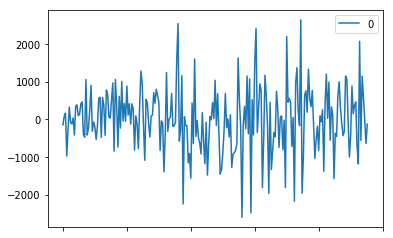

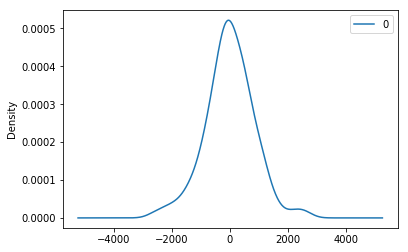

In [40]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# plot kernel density estimation
residuals.plot(kind='kde')
plt.show()

In [41]:
# descriptive statistics on residual
print(residuals.describe())

                 0
count   239.000000
mean      1.740369
std     842.930634
min   -2603.951766
25%    -460.324424
50%     -12.413748
75%     481.351488
max    2639.978807


In [42]:
#
# rolling prediction (verify model): month +2, since the train
#     includes 2017-01.
#
# Note: rolling prediction is required since there is an implicit
#       dependence on observations in prior time steps inheritted
#       when autogressive (AR) model was defined.
#
history = [x for x in df_train]
predictions = list()
iterations = (12-len(df_test)) + 18

for t in range(iterations):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    if t > 10:
        year = 2018
        month = (t+2) % 12
        if month == 0:
            month = 12
    else:
        year = 2017
        month = t+2
        if month == 0:
            month = 12

    print('\n===============================================')
    print('date: {}-{:01d}'.format(year, month))
    print('-----------------------------------------------')

    #
    # observation: if current value doesn't exist from test, append current
    #     predition, to ensure successive rolling prediction computed.
    #
    try:
        obs = df_test[t]
        print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
        print('prediction difference: {:03f}'.format(abs(1-float(yhat)/obs)))
        print('\n===============================================')
        error = mean_squared_error(df_test, predictions)
        print('Test MSE: {:03f}\n\n'.format(error))
    except:
        obs = yhat
        print('predicted={:03f}'.format(float(yhat)))

    history.append(obs)

C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra


date: 2017-2
-----------------------------------------------
predicted=352651.824387, expected=356350.000000
prediction difference: 0.010378

predicted=352651.824387

date: 2017-3
-----------------------------------------------
predicted=354530.719940, expected=357950.000000
prediction difference: 0.009552

predicted=354530.719940

date: 2017-4
-----------------------------------------------
predicted=356340.426579, expected=359250.000000
prediction difference: 0.008099

predicted=356340.426579

date: 2017-5
-----------------------------------------------
predicted=358085.255156, expected=357300.000000
prediction difference: 0.002198

predicted=358085.255156

date: 2017-6
-----------------------------------------------
predicted=359800.263330, expected=357700.000000
prediction difference: 0.005872

predicted=359800.263330

date: 2017-7
-----------------------------------------------
predicted=361495.541155, expected=358850.000000
prediction difference: 0.007372

predicted=361495.54115

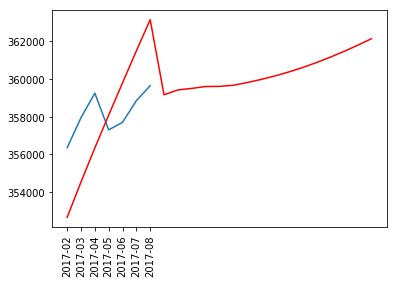

In [43]:
# plot rolling prediction
plt.plot(df_test)
plt.plot(predictions, color='red')
plt.xticks(rotation=90)
plt.show()

In [52]:
# stationarity test
def difference(dataset, delta):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - delta]
        diff.append(value)
    return pd.Series(diff)

def compute_arima(df_train):
    #
    # Note: rolling prediction is required since there is an implicit
    #       dependence on observations in prior time steps inheritted
    #       when autogressive (AR) model was defined.
    #
    history = [x for x in df_train]
    predictions = list()
    iterations = (12-len(df_test)) + 18

    for t in range(iterations):
        delta = 0
        model_fit = False

        #
        # determine stationarity value: no need to difference more than
        #     one third the length of the given series.
        #
        # @delta, the difference factor.
        #
        for delta in range(int(len(history) / 3)):
            stationary = difference(history, delta)
            stationary.index = history[1:]
            result = adfuller(stationary)
            print('delta: {}, p: {}'.format(delta, result[1]))

            #
            # generate model: use dickey-fuller significance test using
            #     custom 'difference' function. Sometimes, statsmodel's
            #     arima algorithm will not agree with our pvalue, so it
            #     is forced to search for another significant difference.
            #
            if (result[1] <= 0.05):
                try:
                    model = ARIMA(history, order=(delta, 2, 2))
                    model_fit = model.fit(disp=0)
                    break
                except:
                    print('stationarity not adequate')
                    continue

        #
        # bad condition: no significant stationarity found on given delta,
        #     so have to pick any next one that works.
        #        
        if not model_fit:
            for delta2 in range(delta, len(history)):
                try:
                    model = ARIMA(history, order=(delta2, 2, 2))
                    model_fit = model.fit(disp=0)
                    break
                except:
                    print('bad condition: stationarity not adequate')
                    continue

        # generate forecast
        output = model_fit.forecast()
        yhat = output[0]

        #
        # observation: if current value doesn't exist from test, append current
        #     predition, to ensure successive rolling prediction computed.
        #
        try:
            obs = df_test[t]
        except:
            obs = yhat
        history.append(obs)
        
        predictions.append(yhat)
        print('predictions: {}'.format(predictions))

    return(predictions)

def get_zipcode(city, state):
    result = zipcodes.filter_by(
        zipcodes.list_all(),
        active=True,
        city=city,
        state=state
    )

    if result and result[0] and result[0]['zip_code']:
        return(result[0]['zip_code'])
    else:
        return(0)

In [45]:
# add zipcode column
df['zip_code'] = df[['City', 'State']].apply(
    lambda x: get_zipcode(
        x['City'].upper(),
        x['State'].upper()
    ),
    axis=1
)

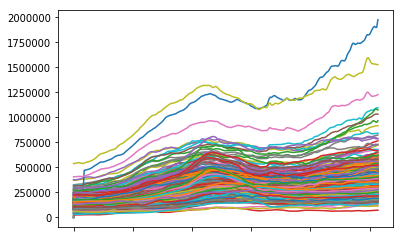

In [46]:
# group by zipcode
df_zipcode = df.groupby('zip_code').agg(np.median).dropna().T

#
# remove columns: column 0 indicates an NaN column
#
df_zipcode_clean = df_zipcode.drop([
    'RegionName',
    'RegionID',
    'SizeRank'
], axis=0)
df_zipcode_clean = df_zipcode_clean.drop([0], axis=1)

df_zipcode_clean.plot(legend=None)
plt.show()

In [51]:
# iterate columns
results = []
for column in df_zipcode_clean:
    predictions = compute_arima(df_zipcode_clean[column])
    results.append({
        'zip_code': df_zipcode_clean[column].name,
        'predictions': predictions
    })

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


delta: 0, p: nan
delta: 1, p: 0.43581480343739437
delta: 2, p: 0.09602268561265981
delta: 3, p: 0.12330830782157487
delta: 4, p: 0.13016438413596815
delta: 5, p: 0.10373052767375313
delta: 6, p: 0.1603877865387051
delta: 7, p: 0.042705747735187594
predictions: [array([343970.13104049])]
delta: 0, p: nan
delta: 1, p: 0.803479384907082
delta: 2, p: 0.5858174147921911
delta: 3, p: 0.4905951809167539
delta: 4, p: 0.6352038915219083
delta: 5, p: 0.5339802889265176
delta: 6, p: 0.5145835730456775
delta: 7, p: 0.2100479142753809
delta: 8, p: 0.09267183040773197
delta: 9, p: 1.2471231454619788e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:676: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


stationarity not adequate
delta: 10, p: 1.4604156810534592e-13
predictions: [array([343970.13104049]), array([375742.41165911])]
delta: 0, p: nan
delta: 1, p: 0.07300563080716499
delta: 2, p: 0.016393091796733494
predictions: [array([343970.13104049]), array([375742.41165911]), array([354616.6154621])]
delta: 0, p: nan
delta: 1, p: 0.01955523947984029
predictions: [array([343970.13104049]), array([375742.41165911]), array([354616.6154621]), array([362401.67226232])]
delta: 0, p: nan
delta: 1, p: 0.015378042382430518
predictions: [array([343970.13104049]), array([375742.41165911]), array([354616.6154621]), array([362401.67226232]), array([356351.11904271])]
delta: 0, p: nan
delta: 1, p: 0.005467578110466673
stationarity not adequate
delta: 2, p: 0.0038685256225786547
predictions: [array([343970.13104049]), array([375742.41165911]), array([354616.6154621]), array([362401.67226232]), array([356351.11904271]), array([359877.29217599])]
delta: 0, p: nan
delta: 1, p: 0.005722751589500754
pre

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:207: RuntimeWarning: invalid value encountered in greater
  if teststat > maxstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:209: RuntimeWarning: invalid value encountered in less
  elif teststat < minstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:211: RuntimeWarning: invalid value encountered in less_equal
  if teststat <= starstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less_equal


delta: 0, p: [nan]
delta: 1, p: [5.42177308e-05]
predictions: [array([343970.13104049]), array([375742.41165911]), array([354616.6154621]), array([362401.67226232]), array([356351.11904271]), array([359877.29217599]), array([360177.01073446]), array([360751.42724862]), array([362096.88164207])]
delta: 0, p: [nan]
delta: 1, p: [5.22014134e-05]
predictions: [array([343970.13104049]), array([375742.41165911]), array([354616.6154621]), array([362401.67226232]), array([356351.11904271]), array([359877.29217599]), array([360177.01073446]), array([360751.42724862]), array([362096.88164207]), array([363531.40484366])]
delta: 0, p: [nan]
delta: 1, p: [5.04307235e-05]
predictions: [array([343970.13104049]), array([375742.41165911]), array([354616.6154621]), array([362401.67226232]), array([356351.11904271]), array([359877.29217599]), array([360177.01073446]), array([360751.42724862]), array([362096.88164207]), array([363531.40484366]), array([364999.24655593])]
delta: 0, p: [nan]
delta: 1, p: [4

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


stationarity not adequate
delta: 8, p: 1.8510848557543063e-06
stationarity not adequate
delta: 9, p: 4.222089952338704e-07
stationarity not adequate
delta: 10, p: 0.00010546651779715653
stationarity not adequate
delta: 11, p: 0.0003965359118261057
stationarity not adequate
delta: 12, p: 0.0011514255366822834
stationarity not adequate
delta: 13, p: 0.00277494320914523
stationarity not adequate
delta: 14, p: 0.0056337135778882505
stationarity not adequate
delta: 15, p: 0.009876911526231704
stationarity not adequate
delta: 16, p: 0.0005959289512536749
stationarity not adequate
delta: 17, p: 0.0010429076466532464
stationarity not adequate
delta: 18, p: 0.03184380730554397
stationarity not adequate
delta: 19, p: 0.0428452786947904
stationarity not adequate
delta: 20, p: 0.05544982106698026
delta: 21, p: 0.07101846902958575
delta: 22, p: 0.08778485839305611
delta: 23, p: 0.10495615628549015
delta: 24, p: 0.12249667563469557
delta: 25, p: 0.1402871263963803
delta: 26, p: 0.15819235881319155
d

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [26]:
# compare first test instance against last prediction instance
print(len(results['predictions']))

TypeError: list indices must be integers or slices, not str